<a href="https://colab.research.google.com/github/burakemretetik/makemore/blob/main/makemore_mlp.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## MLP

## Setup

In [1]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
words = open("names.txt", "r").read().splitlines()
words[:5]

['emma', 'olivia', 'ava', 'isabella', 'sophia']

In [126]:
# build the vocabulary of characters
chars = sorted(list(set("".join(words))))
stoi = {s:i+1 for i, s in enumerate(chars)}
stoi["."] = 0
itos = {i:s for s, i in stoi.items()}
print(itos)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}


In [127]:
# build the dataset

def build_dataset(words, display = False):
  block_size = 3 # Context length: how many characters do we take to predict the next one
  X, Y = [], []

  for w in words[:5]:
      context = [0] * block_size
      for ch in w + ".":
          ix = stoi[ch]
          X.append(context)
          Y.append(ix)
          if display == True: print(''.join(itos[i] for i in context), '--->', itos[ix])
          context = context[1:] + [ix] # Crop and append

  X = torch.tensor(X)
  Y = torch.tensor(Y)
  print(X.shape(), Y.shape())
  return X, Y

build_dataset(words, display = True)

... ---> e
..e ---> m
.em ---> m
emm ---> a
mma ---> .
... ---> o
..o ---> l
.ol ---> i
oli ---> v
liv ---> i
ivi ---> a
via ---> .
... ---> a
..a ---> v
.av ---> a
ava ---> .
... ---> i
..i ---> s
.is ---> a
isa ---> b
sab ---> e
abe ---> l
bel ---> l
ell ---> a
lla ---> .
... ---> s
..s ---> o
.so ---> p
sop ---> h
oph ---> i
phi ---> a
hia ---> .


TypeError: 'torch.Size' object is not callable

In [5]:
X.shape, X.dtype, Y.shape, Y.dtype # Dataset

(torch.Size([32, 3]), torch.int64, torch.Size([32]), torch.int64)

In [6]:
g = torch.Generator().manual_seed(2147483647)
C = torch.randn((27, 2), generator=g)
W1 = torch.randn((6, 100), generator=g)
b1 = torch.randn(100, generator=g)
W2 = torch.randn((100, 27), generator=g)
b2 = torch.randn(27, generator=g)
parameters = [C, W1, b1, W2, b2]

In [7]:
sum(p.nelement() for p in parameters) # Numbers of parameters

3481

In [8]:
for p in parameters:
    p.requires_grad = True

In [9]:
for _ in range(10):
  # Forward pass
  emb = C[X] #(32, 3, 2)
  h = torch.tanh(emb.view(-1, 6) @ W1 + b1) # (32, 100)
  logits = h @ W2 + b2 # h=(32,100) . W=(100,27)
  counts = logits.exp()
  prob = counts / counts.sum(1, keepdims=True)
  loss = -prob[torch.arange(32), Y].log().mean()
  print(loss.item())

  # Backward pass
  for p in parameters:
      p.grad = None
  loss.backward()

  # Update
  for p in parameters:
      p.data += -0.1 * p.grad

17.769710540771484
13.656402587890625
11.298768043518066
9.452457427978516
7.984262466430664
6.891321182250977
6.100014686584473
5.4520368576049805
4.8981523513793945
4.414664268493652


Note: we're overfitting the model here (too few examples for a large dataset will result poor in the actual data)

## Adjust

In [53]:
# Rebuild the dataset (with full data)

block_size = 3 # context length: how many characters do we take to predict the next one
X, Y = [], []

for w in words:
    context = [0] * block_size
    for ch in w + ".":
        ix = stoi[ch]
        X.append(context)
        Y.append(ix)
        context = context[1:] + [ix]

X = torch.tensor(X)
Y = torch.tensor(Y)

X.shape, X.dtype, Y.shape, Y.dtype # Dataset

(torch.Size([228146, 3]), torch.int64, torch.Size([228146]), torch.int64)

In [54]:
# Setup parameters
g = torch.Generator().manual_seed(2147483647)
C = torch.randn((27, 2), generator=g)
W1 = torch.randn((6, 100), generator=g)
b1 = torch.randn(100, generator=g)
W2 = torch.randn((100, 27), generator=g)
b2 = torch.randn(27, generator=g)
parameters = [C, W1, b1, W2, b2]

for p in parameters:
    p.requires_grad = True

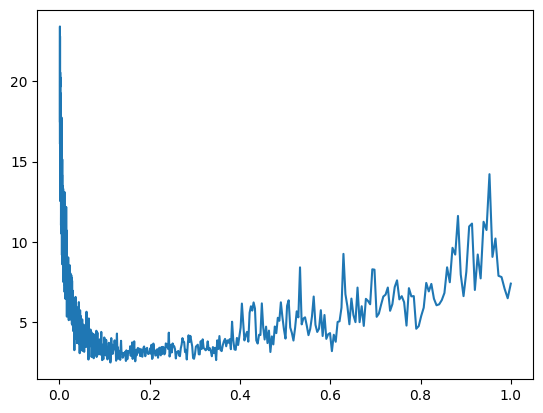

In [46]:
# Deciding leanring rate
lre = torch.linspace(-3, 0, 1000)
lrs = 10**lre

lri = []
lossi = []

for i in range(1000):
  # Minibatch
  ix = torch.randint(0, X.shape[0], (32,))

  # Forward pass
  emb = C[X[ix]] #(32, 3, 2)
  h = torch.tanh(emb.view(-1, 6) @ W1 + b1) # (32, 100)
  logits = h @ W2 + b2 # h=(32,100) . W=(100,27)
  loss = F.cross_entropy(logits, Y[ix])

  # Backward pass
  for p in parameters:
      p.grad = None
  loss.backward()

  # Update
  lr = lrs[i]
  for p in parameters:
      p.data += -lr * p.grad

  # Track the stats
  lri.append(lr)
  lossi.append(loss.item())

plt.plot(lri, lossi)

It looks like 0.1 is a good learning rate to initialize.

## Train

In [118]:
# Reset parameters
g = torch.Generator().manual_seed(2147483647)
C = torch.randn((27, 2), generator=g)
W1 = torch.randn((6, 100), generator=g)
b1 = torch.randn(100, generator=g)
W2 = torch.randn((100, 27), generator=g)
b2 = torch.randn(27, generator=g)
parameters = [C, W1, b1, W2, b2]

for p in parameters:
    p.requires_grad = True

In [119]:
lr = 0.1
losses = []
lrs = []

for _ in range(5):
  lrs.append(lr)
  for i in range(100):
    # Minibatch
    ix = torch.randint(0, X.shape[0], (32,), generator = g)

    # Forward pass
    emb = C[X[ix]] #(32, 3, 2)
    h = torch.tanh(emb.view(-1, 6) @ W1 + b1) # (32, 100)
    logits = h @ W2 + b2 # h=(32,100) . W=(100,27)
    loss = F.cross_entropy(logits, Y[ix])

    # Backward pass
    for p in parameters:
        p.grad = None
    loss.backward()

    # Update
    for p in parameters:
        p.data += -lr * p.grad

    # Track
    losses.append(loss.item())

  lr = lr * 0.75
  print(loss.item())

3.682828426361084
2.7850520610809326
2.9104599952697754
2.733823299407959
2.856456995010376


[0.1,
 0.07500000000000001,
 0.05625000000000001,
 0.0421875,
 0.031640625000000006]

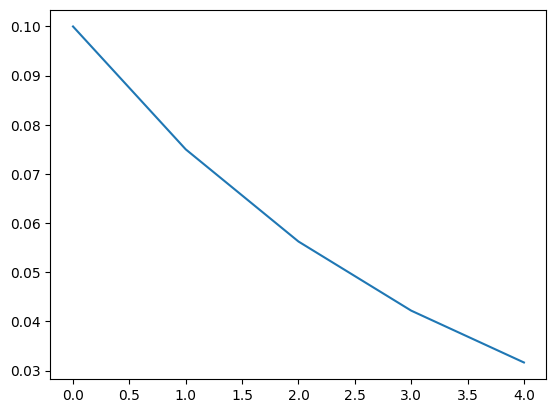

In [120]:
plt.plot(lrs) # Learning rate decay (100 update for each learing rate below.)
lrs

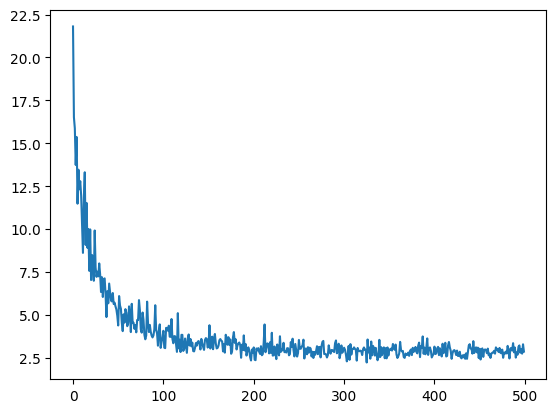

In [121]:
plt.plot(losses)

### Train-Test-Validate

In [ ]:
# Train, test, validation splits = (%80, %10, %10)

